In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from Energy.HelpFunctions.date_and_time import most_recent_thursday, split_time
from Energy.Models.baseline import baseline
from Energy.HelpFunctions.calc_score import evaluate_horizon
from Energy.Models.Model1 import model1

# import importlib
# importlib.reload(Energy.Models)

In [4]:
df = get_energy_data()
df = prepare_data(df)

  0%|          | 0/256 [00:00<?, ?it/s]/Users/elias/Desktop/PTSFC/Energy/HelpFunctions/get_energy_data.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 256/256 [00:43<00:00,  5.95it/s]


In [5]:
# baseline(df, LAST_IDX=-1)
# model1(df)

# Cross validate baseline model

Remove everything til last thursday night 12pm

In [6]:
start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

In [7]:
# baseline(df_cval, LAST_IDX=-1)
model1(df_cval)

,forecast_date,q0.025,q0.25,q0.5,q0.75,q0.975,horizon,target
0,2023-11-10 12:00:00,51.117004,63.483001,67.313252,70.632750,75.347749,36 hour,energy
1,2023-11-10 16:00:00,51.117004,63.483001,67.313252,70.632750,75.347749,40 hour,energy
2,2023-11-10 20:00:00,46.923001,56.038000,60.062752,63.489500,68.797452,44 hour,energy
3,2023-11-11 12:00:00,44.053504,53.248750,57.490751,61.055501,65.705296,60 hour,energy
4,2023-11-11 16:00:00,44.053504,53.248750,57.490751,61.055501,65.705296,64 hour,energy
5,2023-11-11 20:00:00,39.859501,45.803750,50.240250,53.912251,59.154999,68 hour,energy


Repeatedly run the model. Record predictions and true values (observations). Make sure the observations are available for the most recent prediction.

In [8]:
evaluation = pd.DataFrame()
df_before = df_cval
for w in range(100):
    # Create a temp df that only contains the values used for training
    df_before, df_after = split_time(df_before, num_weeks=1)
    pred = baseline(df_before, LAST_IDX=-1)
    # pred = model1(df_before)
    # Transform the observations to timeseries with same index and then merge
    obs = pd.DataFrame({'gesamt': df_cval.loc[pred['forecast_date']]["gesamt"]})
    pred = pred.set_index('forecast_date')
    merged_df = pd.merge(pred, obs, left_index=True, right_index=True) 
    
    # Add scores to the merged_df
    for index, row in merged_df.iterrows():
        quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
        observation = row['gesamt']
        score = evaluate_horizon(quantile_preds, observation)
        merged_df.at[index, 'score'] = score
    # print(merged_df[['q0.025','q0.25','q0.5','q0.75','q0.975']])
    evaluation = pd.concat([evaluation, merged_df])
    

In [9]:
evaluation[evaluation['horizon'] == '36 hour']

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,gesamt,score
forecast_date,,,,,,,,,
2023-11-03 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,67.496313,75.325700,65.95400,6.751672
2023-10-27 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.005250,75.325700,66.15400,7.206141
2023-10-20 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.005250,75.325700,69.16975,12.550891
2023-10-13 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.295063,75.325700,65.68725,6.884297
2023-10-06 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.334312,75.325700,64.72350,5.940172
...,...,...,...,...,...,...,...,...,...
2022-01-07 12:00:00,energy,36 hour,50.738319,63.703250,66.714000,70.733125,73.924913,73.27550,16.320517
2021-12-31 12:00:00,energy,36 hour,50.738319,63.846187,66.769000,70.795625,73.924913,56.43350,29.794923
2021-12-24 12:00:00,energy,36 hour,50.738319,64.077875,66.801375,70.935063,73.924913,59.74025,20.324298


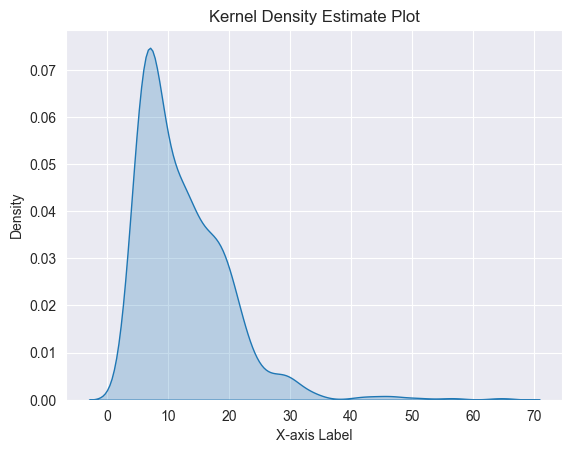

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (replace with your actual data)
data = evaluation['score']

# Kernel density estimate plot
sns.kdeplot(data, fill=True)

# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.title('Kernel Density Estimate Plot')

# Display the plot
plt.show()

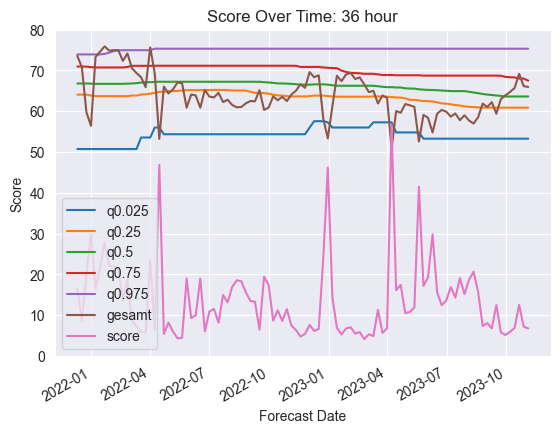

In [11]:
import matplotlib.pyplot as plt

horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']

# for h in horizons:

ax = evaluation[evaluation['horizon'] == '36 hour'].plot(kind='line',  linestyle='-')

# Adding labels and title
plt.xlabel('Forecast Date')
plt.ylabel('Score')
plt.title('Score Over Time: ' + '36 hour')
ax.set_ylim(0, 80)
# Display the plot
plt.show()


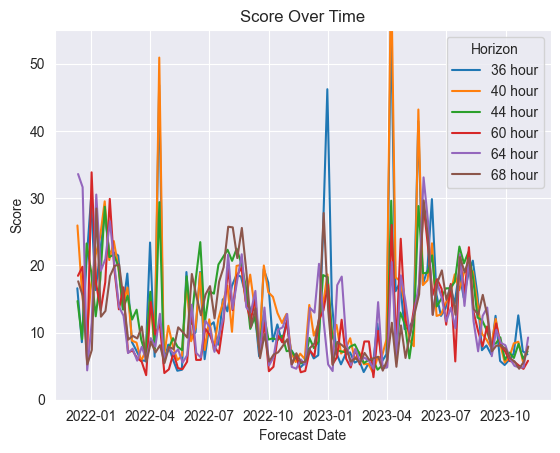

In [12]:
import matplotlib.pyplot as plt

# List of horizons
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']

# Plotting all lines in one plot
plt.figure()  # Create a new figure
for h in horizons:
    subset = evaluation[evaluation['horizon'] == h]
    plt.plot(subset.index, subset['score'], label=h)

# Adding labels and title
plt.xlabel('Forecast Date')
plt.ylabel('Score')
plt.title('Score Over Time')

# Setting y-axis limit
plt.ylim(0,55)

# Adding legend
plt.legend(title='Horizon')

# Display the plot
plt.show()

It can be seen that the heavy outliers are 36 and 44 hour. Is it due to workdays (where production is still active) or not active?
==> CHeck for Holydays

YES! The orange outliers seem to be on Karfreitag.

It can also be seen, that 60-68 hour-forecasts seem to have less extreme outliers

# Cross-validate multiple models

In [13]:

def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
    
    model_evaluations = []
    scores = pd.DataFrame()
    
    df_before = df
    for w in range(last_x):
        df_before, df_after = split_time(df_before, num_weeks=1)
        
    for m in models:
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)
        pred = model['function'](df_before)
        obs = pd.DataFrame({'gesamt': df.loc[pred['forecast_date']]["gesamt"]})
        pred = pred.set_index('forecast_date')
        merged_df = pd.merge(pred, obs, left_index=True, right_index=True) 
    
    
         # Add scores to the merged_df
        for index, row in merged_df.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['gesamt']
            score = evaluate_horizon(quantile_preds, observation)
            merged_df.at[index, 'score'] = score
        # print(merged_df[['q0.025','q0.25','q0.5','q0.75','q0.975']])
        evaluation = pd.concat([evaluation, merged_df])
    return evaluation

## Test the evaluation with baseline and model1

In [14]:
models = [
    {
        'name': 'baseline',
        'function': baseline
     },
    {
        'name': 'model1',
        'function': model1
    }
]

start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

In [15]:
evaluate_models(models, df_cval, last_x=100, weeks=True)

### Plot the distributions of the scores

In [16]:
scores = [m['evaluation']['score'][m['evaluation']['horizon'] == '36 hour'] for m in models]
names = [m['name'] for m in models]
score_df = pd.concat(scores, axis=1,keys=names)

In [17]:
score_df

,baseline,model1
forecast_date,,
2023-11-03 12:00:00,6.751672,6.210303
2023-10-27 12:00:00,7.206141,6.039486
2023-10-20 12:00:00,12.550891,6.491744
2023-10-13 12:00:00,6.884297,6.581562
2023-10-06 12:00:00,5.940172,7.567504
...,...,...
2022-01-07 12:00:00,16.320517,12.172010
2021-12-31 12:00:00,29.794923,34.966651
2021-12-24 12:00:00,20.324298,25.353044


Horizons don't seem to fit!

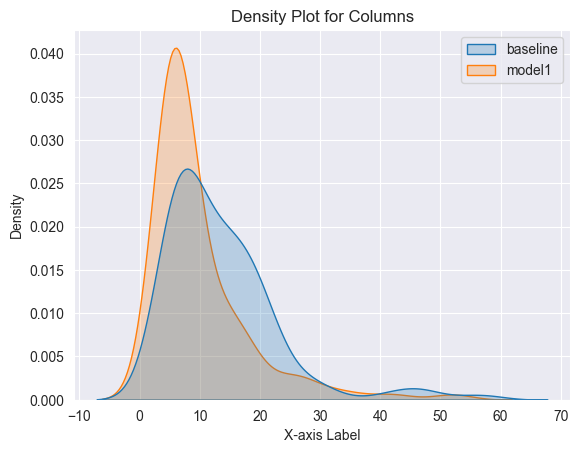

In [19]:
sns.kdeplot(data=score_df, fill=True)

# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.title('Density Plot for Columns')

# Display the plot
plt.show()